<a href="https://colab.research.google.com/github/Mfys212/GNN-for-Molekul-Classifier/blob/main/GNN_Molekul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install chembl_webresource_client
!pip install torch_geometric
!pip install rdkit
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 48.8 MB/s eta 0:00:00


In [14]:
# from chembl_webresource_client.new_client import new_client
import pandas as pd
import torch
from torch import nn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as DL_geo
from torch_geometric.nn import GCNConv, global_mean_pool, GINEConv
from torch.utils.data import DataLoader, TensorDataset
from rdkit import Chem
from rdkit.Chem import rdmolops, AllChem, Draw
import torch.nn.functional as F
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import concurrent.futures
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# target = new_client.target
# target_query = target.search('PI3K (Phosphoinositide 3-kinases)')
# targets = pd.DataFrame.from_dict(target_query)
# targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Homo sapiens,Phosphatidylinositol-4-phosphate 3-kinase C2 d...,26.0,False,CHEMBL5554,"[{'accession': 'O00750', 'component_descriptio...",SINGLE PROTEIN,9606.0
1,[],Homo sapiens,Phosphatidylinositol-4-phosphate 3-kinase C2 d...,24.0,False,CHEMBL1163120,"[{'accession': 'O75747', 'component_descriptio...",SINGLE PROTEIN,9606.0
2,[],Rattus norvegicus,Phosphatidylinositol 3-kinase catalytic subuni...,24.0,False,CHEMBL5291577,"[{'accession': 'O88763', 'component_descriptio...",SINGLE PROTEIN,10116.0
3,[],Homo sapiens,VPS15-VPS34,24.0,False,CHEMBL5483084,"[{'accession': 'Q8NEB9', 'component_descriptio...",PROTEIN COMPLEX,9606.0
4,[],Homo sapiens,Phosphatidylinositol-4-phosphate 3-kinase C2 d...,23.0,False,CHEMBL1075102,"[{'accession': 'O00443', 'component_descriptio...",SINGLE PROTEIN,9606.0
...,...,...,...,...,...,...,...,...,...
3094,[],Homo sapiens,Ubiquitin-like domain-containing CTD phosphata...,0.0,False,CHEMBL3317333,"[{'accession': 'Q8WVY7', 'component_descriptio...",SINGLE PROTEIN,9606.0
3095,[],Homo sapiens,Protein phosphatase 1G,0.0,False,CHEMBL3351199,"[{'accession': 'O15355', 'component_descriptio...",SINGLE PROTEIN,9606.0
3096,[],Homo sapiens,Serine/threonine-protein phosphatase 5,0.0,False,CHEMBL3425389,"[{'accession': 'P53041', 'component_descriptio...",SINGLE PROTEIN,9606.0
3097,[],Homo sapiens,80S Ribosome,0.0,False,CHEMBL3987582,"[{'accession': 'P08865', 'component_descriptio...",PROTEIN NUCLEIC-ACID COMPLEX,9606.0


In [ ]:
# def targetFilter(selected_target):
#     activity = new_client.activity
#     res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")
#     df = pd.DataFrame.from_dict(res)
#     return df

In [ ]:
# targets_new = targets[targets['organism'] == 'Homo sapiens']
# unique_ids = targets_new['target_chembl_id'].unique().tolist()
# df = []
# for i in tqdm(unique_ids[:100], desc="Processing IDs", unit="ID"):
#     df.append(targetFilter(i))
# df = pd.concat(df)

Processing IDs: 100%|██████████| 100/100 [00:09<00:00, 10.84ID/s]
<ipython-input-10-5bf85b438076>:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(df)


In [ ]:
# selection = ['molecule_chembl_id', 'canonical_smiles','standard_value']
# df_prep = df[selection].dropna()

# df_prep_label = df_prep.copy()
# bioactivity_threshold = []
# for i in df_prep_label.standard_value:
#     if float(i) >= 10000:
#         bioactivity_threshold.append("inactive")
#     elif float(i) <= 1000:
#         bioactivity_threshold.append("active")
#     else:
#         bioactivity_threshold.append("intermediate")

# df_prep_label['class'] = bioactivity_threshold
# df_2class = df_prep_label[df_prep_label['class'] != 'intermediate'].reset_index(drop=True)

In [ ]:
# df_2class.to_csv('PI3K (Phosphoinositide 3-kinases).csv', index=False)
# from google.colab import files
# files.download('PI3K (Phosphoinositide 3-kinases).csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
df_2class_prep = pd.read_csv('https://github.com/Mfys212/GNN-for-Molekul-Classifier/raw/refs/heads/main/PI3K%20(Phosphoinositide%203-kinases).csv')
df_2class_prep

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL541133,Cc1ccc([N+](=O)[O-])cc1S(=O)(=O)c1nc(-c2cnc3cc...,100.00,active
1,CHEMBL538346,Cl.Oc1cccc(-c2nc(N3CCOCC3)c3oc4ncccc4c3n2)c1,10.00,active
2,CHEMBL541643,Cl.Oc1cccc(-c2nc(N3CCOCC3)c3sccc3n2)c1,220.00,active
3,CHEMBL556399,Cc1ccc([N+](=O)[O-])cc1S(=O)(=O)N(C)/N=C/c1cnc...,100.00,active
4,CHEMBL538346,Cl.Oc1cccc(-c2nc(N3CCOCC3)c3oc4ncccc4c3n2)c1,10.00,active
...,...,...,...,...
42358,CHEMBL3745885,Cn1c(=O)c(S(=O)(=O)c2ccc(F)cc2F)cc2cnc(Nc3ccc4...,10000.00,inactive
42359,CHEMBL4069365,CC1(C)OCC(=O)Nc2cc(Nc3nc(NCC(F)(F)F)c4occc4n3)...,10000.00,inactive
42360,CHEMBL388978,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,17.20,active
42361,CHEMBL388978,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,2.54,active


In [4]:
data = df_2class_prep[["canonical_smiles", "class"]]
print(data.isnull().sum(), "\n")
data.info()

canonical_smiles    0
class               0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42363 entries, 0 to 42362
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   canonical_smiles  42363 non-null  object
 1   class             42363 non-null  object
dtypes: object(2)
memory usage: 662.0+ KB


In [5]:
smiles = []
for i in data.canonical_smiles.tolist():
    cpd = str(i).split('.')
    cpd_longest = max(cpd, key = len)
    smiles.append(cpd_longest)

df_clean = data.copy()
df_clean = df_clean.drop(columns='canonical_smiles')
df_clean['canonical_smiles'] = smiles
df_clean

,class,canonical_smiles
0,active,Cc1ccc([N+](=O)[O-])cc1S(=O)(=O)c1nc(-c2cnc3cc...
1,active,Oc1cccc(-c2nc(N3CCOCC3)c3oc4ncccc4c3n2)c1
2,active,Oc1cccc(-c2nc(N3CCOCC3)c3sccc3n2)c1
3,active,Cc1ccc([N+](=O)[O-])cc1S(=O)(=O)N(C)/N=C/c1cnc...
4,active,Oc1cccc(-c2nc(N3CCOCC3)c3oc4ncccc4c3n2)c1
...,...,...
42358,inactive,Cn1c(=O)c(S(=O)(=O)c2ccc(F)cc2F)cc2cnc(Nc3ccc4...
42359,inactive,CC1(C)OCC(=O)Nc2cc(Nc3nc(NCC(F)(F)F)c4occc4n3)...
42360,active,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...
42361,active,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...


class
active      25610
inactive    16753
Name: count, dtype: int64


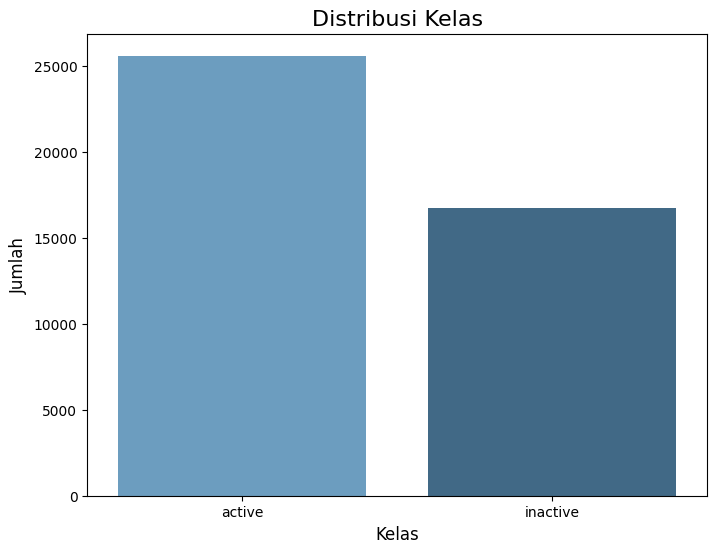

In [15]:
class_counts = df_clean["class"].value_counts()
print(class_counts)
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='Blues_d')
plt.title('Distribusi Kelas', fontsize=16)
plt.xlabel('Kelas', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.xticks(rotation=0)
plt.show()

In [17]:
target_over = 20000
ros = RandomOverSampler(sampling_strategy={'inactive': target_over}, random_state=42)
X_resampled, y_resampled = ros.fit_resample(df_clean[['canonical_smiles']], df_clean['class'])

df_final = pd.DataFrame({
    'canonical_smiles': X_resampled['canonical_smiles'],
    'class': y_resampled
})

In [18]:
print(df_final.info(), "\n")
class_counts = df_final['class'].value_counts()
class_counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45610 entries, 0 to 45609
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   canonical_smiles  45610 non-null  object
 1   class             45610 non-null  object
dtypes: object(2)
memory usage: 712.8+ KB
None 



,count
class,
active,25610
inactive,20000


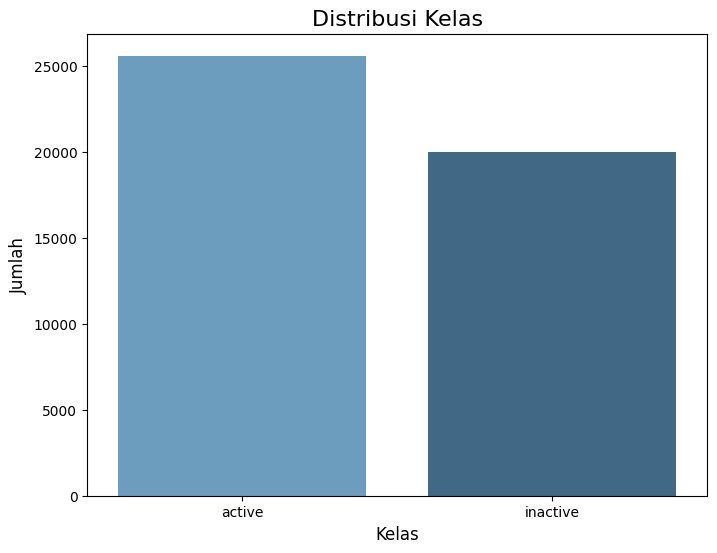

In [19]:
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='Blues_d')
plt.title('Distribusi Kelas', fontsize=16)
plt.xlabel('Kelas', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.xticks(rotation=0)
plt.show()

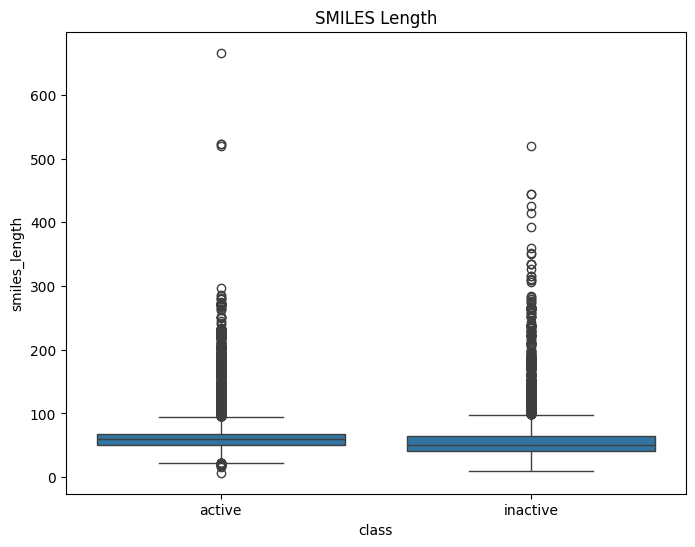

In [21]:
df_final['smiles_length'] = df_final['canonical_smiles'].apply(len)
plt.figure(figsize=(8, 6))
sns.boxplot(x='class', y='smiles_length', data=df_final)
plt.title('SMILES Length')
plt.show()

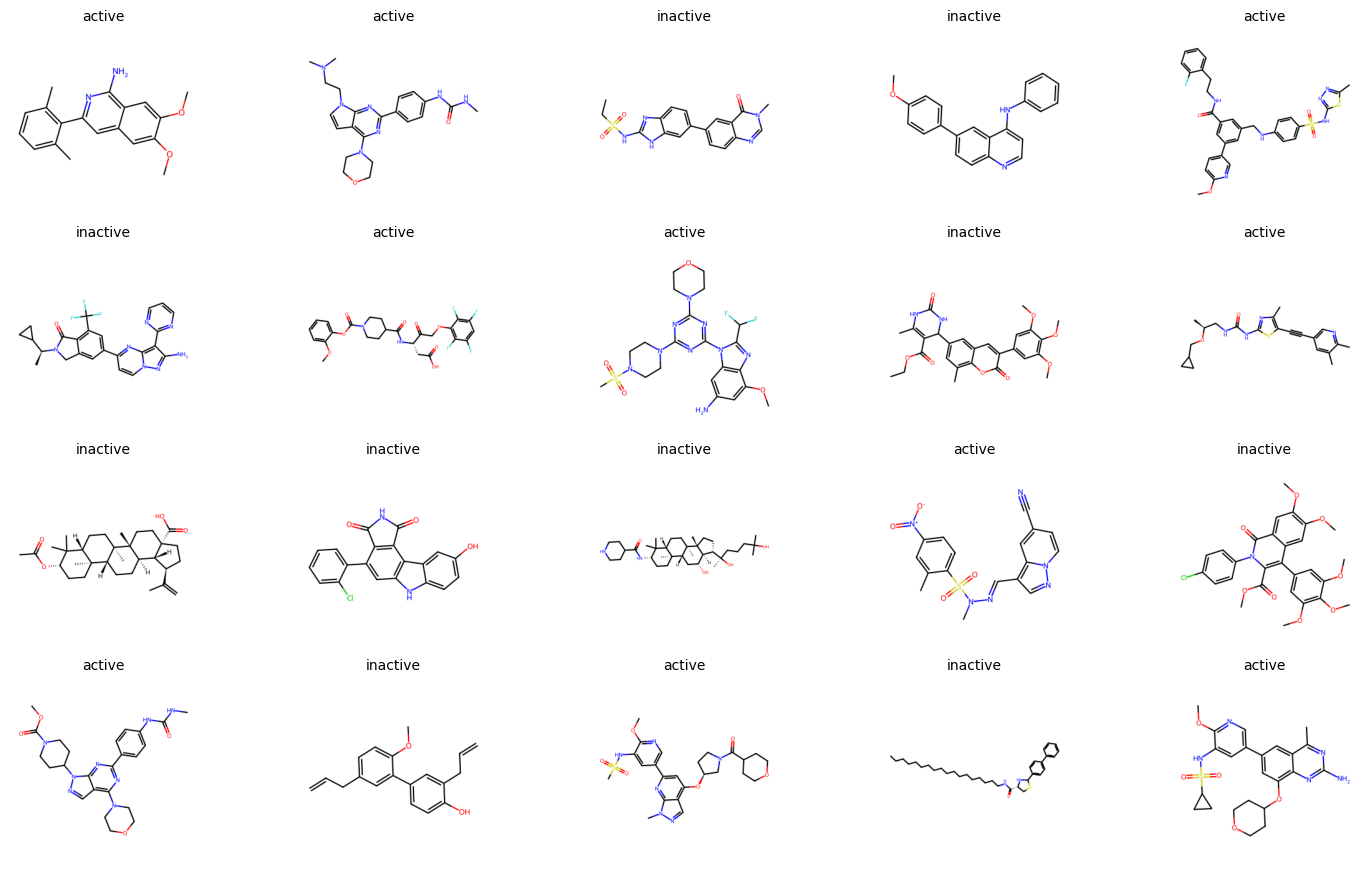

In [53]:
import math
sampled_data, _ = train_test_split(df_final, test_size=0.1, stratify=df_final['class'], random_state=42)
smiles_list = sampled_data['canonical_smiles'][:20].tolist()
label_list = sampled_data['class'][:20].tolist()

fig, axes = plt.subplots(math.ceil(len(smiles_list) / 5), 5, figsize=(15, 10))
for i, smiles in enumerate(smiles_list):
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol)
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"{label_list[i]}", fontsize=10)

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

In [27]:
class LoaderData(nn.Module):
    def __init__(self, X, y, batch=32, test_size=0.2, seed=212, use_y=True):
        super().__init__()
        self.use_y = use_y
        if use_y:
            X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=seed)
            self.batch_size = batch
            self.X_train = X_train
            self.X_test = X_test
            self.y_train = y_train
            self.y_test = y_test

    def process_molecule(self, molecule, cls, use_y=True):
        return self.molecule_to_graph(molecule, cls, use_y)

    def forward(self, x=None):
        with concurrent.futures.ThreadPoolExecutor() as executor:
            if self.use_y:
              train_graphs = list(executor.map(self.process_molecule, self.X_train, self.y_train))
              val_graphs = list(executor.map(self.process_molecule, self.X_test, self.y_test))
            else:
              graphs = self.process_molecule(x, None, self.use_y)

        if self.use_y:
            train_loader = DL_geo(train_graphs, batch_size=self.batch_size, shuffle=True)
            val_loader = DL_geo(val_graphs, batch_size=self.batch_size, shuffle=False)
            return train_loader, val_loader
        else:
            return graphs

    def molecule_to_graph(self, molecule: str, y=None, use_y=True):
        mol = Chem.MolFromSmiles(molecule)
        if mol is None:
            return None

        atoms = [
            [
                atom.GetAtomicNum(),              # Nomor atom
                atom.GetMass(),                   # Massa atom
                int(atom.GetIsAromatic()),        # Apakah atom aromatik
                int(atom.GetHybridization()),     # Tipe hibridisasi
                atom.GetFormalCharge(),           # Muatan formal
                atom.GetDegree(),                 # Derajat atom
                atom.GetImplicitValence(),        # Valensi implisit
                atom.GetExplicitValence(),        # Valensi eksplisit
                int(atom.IsInRing()),             # Apakah dalam cincin
                int(atom.GetChiralTag()),         # Tag kiralitas
            ]
            for atom in mol.GetAtoms()
        ]

        edges = []
        edge_attr = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edges.append([i, j])
            edges.append([j, i])  # kedua arah untuk graf tak berarah

            bond_features = [
                bond.GetBondTypeAsDouble(),      # Tipe ikatan
                int(bond.GetIsConjugated()),     # Apakah ikatan terkonjugasi
                int(bond.GetIsAromatic()),       # Apakah ikatan aromatik
                int(bond.GetStereo()),           # Stereokimia ikatan
                int(bond.IsInRing()),            # Apakah ikatan dalam cincin
            ]
            edge_attr.append(bond_features)
            edge_attr.append(bond_features) # fitur edge untuk arah sebaliknya

        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
        x = torch.tensor(atoms, dtype=torch.float)

        if use_y:
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=torch.tensor([y], dtype=torch.long))
        else:
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        return data

class GNNBlock(nn.Module):
    def __init__(self, edge_features, c1, c2, dropout_rate=0.2, c1_=False):
        super().__init__()
        self.conv1 = GINEConv(nn.Linear(c1, c2), edge_dim=edge_features)
        self.conv2 = GINEConv(nn.Linear(c2, c1), edge_dim=edge_features)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, inputs, edge_index, edge_attr):
        x = self.dropout(F.leaky_relu(self.conv1(inputs, edge_index, edge_attr)))
        return self.conv2(x+inputs, edge_index, edge_attr)

class GNNModel(nn.Module):
    def __init__(self, num_features, edge_features, c1=128, c2=128, num_block=2, output_dim=2):
        super().__init__()
        self.inputs = GINEConv(nn.Linear(num_features, c1//2), edge_dim=edge_features)
        self.conv = GINEConv(nn.Linear(c1//2, c1), edge_dim=edge_features)
        self.block = [GNNBlock(edge_features, c1, c2) for i in range(num_block)]
        self.cls = nn.Linear(c1, output_dim)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.leaky_relu(self.inputs(x, edge_index, edge_attr))
        x = self.conv(x, edge_index, edge_attr)
        for block in self.block:
            x = block(x, edge_index, edge_attr)
        x = global_mean_pool(self.cls(x), data.batch)
        return x

class CreateModel(nn.Module):
    def __init__(self,
                 X, y,
                 batch=32,
                 test_size=0.2,
                 output_dim=2,
                 seed=212,
                 c1=128,
                 c2=128,
                 num_block=2,
                 dropout_rate=0.3):
        super().__init__()
        print("Loading data ...")
        self.X, self.y = X, y
        self.loader = LoaderData(X, y, batch, test_size, seed)
        self.train_loader, self.val_loader = self.loader()
        self.num_node_features = self.train_loader.dataset[0].x.size(1)
        self.num_edge_features = self.train_loader.dataset[0].edge_attr.size(1)
        self.model = GNNModel(self.num_node_features, self.num_edge_features, c1, c2, num_block, output_dim)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = self.model.to(self.device)
        print("Successful load model")

    def forward(self, x):
        self.model.eval()
        self.load= LoaderData(self.X, self.y, 1, 0.2, seed=212, use_y=False)
        data = self.load(x=x)
        out = self.model(data)
        return torch.sigmoid(out)

    def predict(self, x):
        return self.forward(x)

    def train(self, optimizer, criterion):
        self.model.train()
        total_loss = 0
        correct = 0
        with tqdm(self.train_loader, desc="Training", unit="batch") as t:
            for data in t:
                data = data.to(self.device)
                optimizer.zero_grad()
                out = self.model(data)
                loss = criterion(out.view(-1), data.y.float())
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                pred = torch.sigmoid(out)
                pred = (pred > 0.5).float()
                correct += (pred.view(-1) == data.y).sum().item()
        avg_loss = total_loss / len(self.train_loader)
        accuracy = correct / len(self.train_loader.dataset)
        return avg_loss, accuracy

    def eval(self, threshold=0.5, probs=False):
        self.model.eval()
        total_loss = 0
        correct = 0
        all_labels, all_preds = [], []
        with tqdm(self.val_loader, desc="Validation", unit="batch") as t:
            with torch.no_grad():
                for data in t:
                    data = data.to(self.device)
                    out = self.model(data)
                    prob = torch.sigmoid(out)
                    pred = (prob > threshold).float()
                    all_labels.extend(data.y.cpu().numpy())
                    all_preds.extend(prob.cpu().numpy())  if probs else all_preds.extend(pred.cpu().numpy())
        return all_labels, all_preds

    def validate(self, criterion):
        self.model.eval()
        total_loss = 0
        correct = 0
        with tqdm(self.val_loader, desc="Validation", unit="batch") as t:
            with torch.no_grad():
                for data in t:
                    data = data.to(self.device)
                    out = self.model(data)
                    loss = criterion(out.view(-1), data.y.float())
                    total_loss += loss.item()
                    pred = torch.sigmoid(out)
                    pred = (pred > 0.5).float()
                    correct += (pred.view(-1) == data.y).sum().item()
        avg_loss = total_loss / len(self.val_loader)
        accuracy = correct / len(self.val_loader.dataset)
        return avg_loss, accuracy

    def fit(self, epochs, optimizer, lr, loss, loss_w=None):
        optimizer, criterion = self.get_optim(optimizer, lr, loss, loss_w)
        t_acc, t_loss, v_acc, v_loss = [], [], [], []
        best_val_loss = float('inf')
        best_model_state_dict = None
        for epoch in range(1, epochs + 1):
            train_loss, train_acc = self.train(optimizer, criterion)
            val_loss, val_accuracy = self.validate(criterion)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state_dict = self.model.state_dict()
            print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}\n")
            t_loss.append(train_loss)
            t_acc.append(train_acc)
            v_loss.append(val_loss)
            v_acc.append(val_accuracy)
        torch.save(self.model.state_dict(), "last.pt")
        if best_model_state_dict:
            self.model.load_state_dict(best_model_state_dict)
            torch.save(self.model.state_dict(), "best.pt")
            print("Restored model to the best state based on validation loss.")
        history = {"Train Loss":t_loss, "Train Acc":t_acc, "Val Loss":v_loss, "Val Acc":v_acc}
        return history

    def get_optim(self, optimizer, lr, loss, loss_w):
        optimizer = optimizer(self.model.parameters(), lr=lr)
        if loss_w is not None:
            try:
              criterion = loss(weight=loss_w)
            except:
              criterion = loss(pos_weight=loss_w)
        else:
            criterion = loss()
        return optimizer, criterion

    def load_state(self, weight):
        self.model.load_state_dict(torch.load(weight))

    def load_model(self, weight):
        self.model = torch.load(weight)

In [28]:
X = df_final['canonical_smiles']
y = df_final['class'].map({'active': 1, 'inactive': 0})
EPOCHS = 100
model = CreateModel(X, y, batch=32, test_size=0.2, output_dim=1, seed=212)

Loading data ...
Successful load model


In [ ]:
loss_weights = torch.tensor([0.85])
history = model.fit(epochs=EPOCHS, optimizer=torch.optim.Adam, lr=0.001, loss=nn.BCEWithLogitsLoss, loss_w=loss_weights)

Validation: 100%|██████████| 286/286 [00:05<00:00, 48.23batch/s]


Epoch 1/100 | Train Loss: 0.7324 | Train Acc: 0.5841 | Val Loss: 0.5287 | Val Acc: 0.6614



Validation: 100%|██████████| 286/286 [00:04<00:00, 61.36batch/s]


Epoch 2/100 | Train Loss: 0.5409 | Train Acc: 0.6505 | Val Loss: 0.5425 | Val Acc: 0.6426



Validation: 100%|██████████| 286/286 [00:05<00:00, 53.23batch/s]


Epoch 3/100 | Train Loss: 0.5292 | Train Acc: 0.6636 | Val Loss: 0.5222 | Val Acc: 0.6711



Validation: 100%|██████████| 286/286 [00:04<00:00, 58.95batch/s]


Epoch 4/100 | Train Loss: 0.5172 | Train Acc: 0.6775 | Val Loss: 0.4978 | Val Acc: 0.7018



Validation: 100%|██████████| 286/286 [00:04<00:00, 61.50batch/s]


Epoch 5/100 | Train Loss: 0.5051 | Train Acc: 0.6903 | Val Loss: 0.5454 | Val Acc: 0.6393



Validation: 100%|██████████| 286/286 [00:05<00:00, 49.81batch/s]


Epoch 6/100 | Train Loss: 0.4993 | Train Acc: 0.6983 | Val Loss: 0.4838 | Val Acc: 0.7296



Validation: 100%|██████████| 286/286 [00:04<00:00, 63.39batch/s]


Epoch 7/100 | Train Loss: 0.4901 | Train Acc: 0.7062 | Val Loss: 0.4797 | Val Acc: 0.7126



Validation: 100%|██████████| 286/286 [00:04<00:00, 61.51batch/s]


Epoch 8/100 | Train Loss: 0.4814 | Train Acc: 0.7154 | Val Loss: 0.4776 | Val Acc: 0.7165



Validation: 100%|██████████| 286/286 [00:05<00:00, 50.15batch/s]


Epoch 9/100 | Train Loss: 0.4729 | Train Acc: 0.7245 | Val Loss: 0.4614 | Val Acc: 0.7401



Validation: 100%|██████████| 286/286 [00:04<00:00, 62.19batch/s]


Epoch 10/100 | Train Loss: 0.4680 | Train Acc: 0.7276 | Val Loss: 0.4541 | Val Acc: 0.7479



Validation: 100%|██████████| 286/286 [00:05<00:00, 56.54batch/s]


Epoch 11/100 | Train Loss: 0.4616 | Train Acc: 0.7325 | Val Loss: 0.4662 | Val Acc: 0.7291



Validation: 100%|██████████| 286/286 [00:05<00:00, 54.49batch/s]


Epoch 12/100 | Train Loss: 0.4522 | Train Acc: 0.7422 | Val Loss: 0.4359 | Val Acc: 0.7554



Validation: 100%|██████████| 286/286 [00:04<00:00, 61.22batch/s]


Epoch 13/100 | Train Loss: 0.4499 | Train Acc: 0.7451 | Val Loss: 0.4551 | Val Acc: 0.7393



Validation: 100%|██████████| 286/286 [00:07<00:00, 38.11batch/s]


Epoch 14/100 | Train Loss: 0.4462 | Train Acc: 0.7485 | Val Loss: 0.4325 | Val Acc: 0.7565



Validation: 100%|██████████| 286/286 [00:04<00:00, 60.34batch/s]


Epoch 15/100 | Train Loss: 0.4405 | Train Acc: 0.7511 | Val Loss: 0.4319 | Val Acc: 0.7571



Validation: 100%|██████████| 286/286 [00:04<00:00, 61.77batch/s]


Epoch 16/100 | Train Loss: 0.4354 | Train Acc: 0.7576 | Val Loss: 0.4220 | Val Acc: 0.7667



Validation: 100%|██████████| 286/286 [00:06<00:00, 46.65batch/s]


Epoch 17/100 | Train Loss: 0.4292 | Train Acc: 0.7607 | Val Loss: 0.4128 | Val Acc: 0.7726



Validation: 100%|██████████| 286/286 [00:05<00:00, 57.19batch/s]


Epoch 18/100 | Train Loss: 0.4266 | Train Acc: 0.7596 | Val Loss: 0.4205 | Val Acc: 0.7655



Validation: 100%|██████████| 286/286 [00:05<00:00, 50.51batch/s]


Epoch 19/100 | Train Loss: 0.4209 | Train Acc: 0.7670 | Val Loss: 0.4139 | Val Acc: 0.7708



Validation: 100%|██████████| 286/286 [00:04<00:00, 60.38batch/s]


Epoch 20/100 | Train Loss: 0.4196 | Train Acc: 0.7701 | Val Loss: 0.3994 | Val Acc: 0.7867



Validation: 100%|██████████| 286/286 [00:05<00:00, 55.78batch/s]


Epoch 21/100 | Train Loss: 0.4119 | Train Acc: 0.7740 | Val Loss: 0.4140 | Val Acc: 0.7757



Validation: 100%|██████████| 286/286 [00:05<00:00, 55.45batch/s]


Epoch 22/100 | Train Loss: 0.4088 | Train Acc: 0.7761 | Val Loss: 0.4382 | Val Acc: 0.7540



Validation: 100%|██████████| 286/286 [00:04<00:00, 61.58batch/s]


Epoch 23/100 | Train Loss: 0.4051 | Train Acc: 0.7793 | Val Loss: 0.4209 | Val Acc: 0.7672



Validation: 100%|██████████| 286/286 [00:05<00:00, 49.18batch/s]


Epoch 24/100 | Train Loss: 0.4017 | Train Acc: 0.7810 | Val Loss: 0.3982 | Val Acc: 0.7870



Validation: 100%|██████████| 286/286 [00:04<00:00, 62.60batch/s]


Epoch 25/100 | Train Loss: 0.4002 | Train Acc: 0.7809 | Val Loss: 0.4134 | Val Acc: 0.7720



Validation: 100%|██████████| 286/286 [00:04<00:00, 61.80batch/s]


Epoch 26/100 | Train Loss: 0.3975 | Train Acc: 0.7833 | Val Loss: 0.3979 | Val Acc: 0.7859



Validation: 100%|██████████| 286/286 [00:05<00:00, 48.87batch/s]


Epoch 27/100 | Train Loss: 0.3942 | Train Acc: 0.7872 | Val Loss: 0.4234 | Val Acc: 0.7717



Validation: 100%|██████████| 286/286 [00:04<00:00, 60.45batch/s]


Epoch 28/100 | Train Loss: 0.3909 | Train Acc: 0.7888 | Val Loss: 0.3861 | Val Acc: 0.7928



Validation: 100%|██████████| 286/286 [00:04<00:00, 57.99batch/s]


Epoch 29/100 | Train Loss: 0.3915 | Train Acc: 0.7893 | Val Loss: 0.4018 | Val Acc: 0.7770



Validation: 100%|██████████| 286/286 [00:05<00:00, 49.06batch/s]


Epoch 30/100 | Train Loss: 0.3887 | Train Acc: 0.7922 | Val Loss: 0.3850 | Val Acc: 0.7994



Validation: 100%|██████████| 286/286 [00:04<00:00, 61.85batch/s]


Epoch 31/100 | Train Loss: 0.3858 | Train Acc: 0.7938 | Val Loss: 0.3806 | Val Acc: 0.7908



Validation: 100%|██████████| 286/286 [00:05<00:00, 52.73batch/s]


Epoch 32/100 | Train Loss: 0.3824 | Train Acc: 0.7955 | Val Loss: 0.3809 | Val Acc: 0.7951



Validation: 100%|██████████| 286/286 [00:04<00:00, 58.06batch/s]


Epoch 33/100 | Train Loss: 0.3802 | Train Acc: 0.7969 | Val Loss: 0.3842 | Val Acc: 0.7940



Validation: 100%|██████████| 286/286 [00:04<00:00, 60.57batch/s]


Epoch 34/100 | Train Loss: 0.3791 | Train Acc: 0.7988 | Val Loss: 0.3753 | Val Acc: 0.8054



Validation: 100%|██████████| 286/286 [00:05<00:00, 48.53batch/s]


Epoch 35/100 | Train Loss: 0.3768 | Train Acc: 0.8000 | Val Loss: 0.3740 | Val Acc: 0.7974



Validation: 100%|██████████| 286/286 [00:04<00:00, 60.85batch/s]


Epoch 36/100 | Train Loss: 0.3772 | Train Acc: 0.8003 | Val Loss: 0.3817 | Val Acc: 0.7989



Validation: 100%|██████████| 286/286 [00:05<00:00, 47.80batch/s]


Epoch 37/100 | Train Loss: 0.3735 | Train Acc: 0.8019 | Val Loss: 0.3725 | Val Acc: 0.8029



Validation: 100%|██████████| 286/286 [00:05<00:00, 50.23batch/s]


Epoch 38/100 | Train Loss: 0.3734 | Train Acc: 0.7989 | Val Loss: 0.3764 | Val Acc: 0.7965



Validation: 100%|██████████| 286/286 [00:04<00:00, 60.33batch/s]


Epoch 39/100 | Train Loss: 0.3728 | Train Acc: 0.8012 | Val Loss: 0.3768 | Val Acc: 0.8014



Validation: 100%|██████████| 286/286 [00:05<00:00, 55.22batch/s]


Epoch 40/100 | Train Loss: 0.3682 | Train Acc: 0.8051 | Val Loss: 0.3746 | Val Acc: 0.8056



Validation: 100%|██████████| 286/286 [00:04<00:00, 58.63batch/s]


Epoch 41/100 | Train Loss: 0.3667 | Train Acc: 0.8072 | Val Loss: 0.3829 | Val Acc: 0.8008



Validation: 100%|██████████| 286/286 [00:04<00:00, 62.13batch/s]


Epoch 42/100 | Train Loss: 0.3645 | Train Acc: 0.8080 | Val Loss: 0.3709 | Val Acc: 0.8053



Validation: 100%|██████████| 286/286 [00:05<00:00, 48.21batch/s]


Epoch 43/100 | Train Loss: 0.3607 | Train Acc: 0.8129 | Val Loss: 0.3570 | Val Acc: 0.8142



Validation: 100%|██████████| 286/286 [00:04<00:00, 61.37batch/s]


Epoch 44/100 | Train Loss: 0.3626 | Train Acc: 0.8074 | Val Loss: 0.3721 | Val Acc: 0.8000



Validation: 100%|██████████| 286/286 [00:05<00:00, 56.39batch/s]


Epoch 45/100 | Train Loss: 0.3622 | Train Acc: 0.8094 | Val Loss: 0.3718 | Val Acc: 0.8026



Validation: 100%|██████████| 286/286 [00:04<00:00, 57.25batch/s]


Epoch 46/100 | Train Loss: 0.3594 | Train Acc: 0.8118 | Val Loss: 0.3588 | Val Acc: 0.8140



Validation: 100%|██████████| 286/286 [00:04<00:00, 60.88batch/s]


Epoch 47/100 | Train Loss: 0.3586 | Train Acc: 0.8107 | Val Loss: 0.3615 | Val Acc: 0.8116



Validation: 100%|██████████| 286/286 [00:05<00:00, 49.25batch/s]


Epoch 48/100 | Train Loss: 0.3566 | Train Acc: 0.8128 | Val Loss: 0.3612 | Val Acc: 0.8100



Validation: 100%|██████████| 286/286 [00:04<00:00, 61.66batch/s]


Epoch 49/100 | Train Loss: 0.3585 | Train Acc: 0.8105 | Val Loss: 0.3864 | Val Acc: 0.7976



Validation: 100%|██████████| 286/286 [00:05<00:00, 54.76batch/s]


Epoch 50/100 | Train Loss: 0.3564 | Train Acc: 0.8120 | Val Loss: 0.3600 | Val Acc: 0.8107



Validation: 100%|██████████| 286/286 [00:05<00:00, 56.19batch/s]


Epoch 51/100 | Train Loss: 0.3535 | Train Acc: 0.8156 | Val Loss: 0.3591 | Val Acc: 0.8163



Validation: 100%|██████████| 286/286 [00:04<00:00, 59.04batch/s]


Epoch 52/100 | Train Loss: 0.3537 | Train Acc: 0.8145 | Val Loss: 0.3656 | Val Acc: 0.8077



Validation: 100%|██████████| 286/286 [00:05<00:00, 48.21batch/s]


Epoch 53/100 | Train Loss: 0.3514 | Train Acc: 0.8151 | Val Loss: 0.3793 | Val Acc: 0.7981



Validation: 100%|██████████| 286/286 [00:04<00:00, 60.91batch/s]


Epoch 54/100 | Train Loss: 0.3519 | Train Acc: 0.8160 | Val Loss: 0.3545 | Val Acc: 0.8179



Validation: 100%|██████████| 286/286 [00:04<00:00, 61.88batch/s]


Epoch 55/100 | Train Loss: 0.3514 | Train Acc: 0.8163 | Val Loss: 0.3548 | Val Acc: 0.8127



Validation: 100%|██████████| 286/286 [00:05<00:00, 48.55batch/s]


Epoch 56/100 | Train Loss: 0.3471 | Train Acc: 0.8185 | Val Loss: 0.3626 | Val Acc: 0.8066



Validation: 100%|██████████| 286/286 [00:04<00:00, 61.85batch/s]


Epoch 57/100 | Train Loss: 0.3469 | Train Acc: 0.8226 | Val Loss: 0.3548 | Val Acc: 0.8190



Validation: 100%|██████████| 286/286 [00:04<00:00, 57.65batch/s]


Epoch 58/100 | Train Loss: 0.3467 | Train Acc: 0.8188 | Val Loss: 0.3502 | Val Acc: 0.8164



Validation: 100%|██████████| 286/286 [00:05<00:00, 51.30batch/s]


Epoch 59/100 | Train Loss: 0.3461 | Train Acc: 0.8215 | Val Loss: 0.3599 | Val Acc: 0.8084



Validation: 100%|██████████| 286/286 [00:05<00:00, 55.49batch/s]


Epoch 60/100 | Train Loss: 0.3473 | Train Acc: 0.8194 | Val Loss: 0.3629 | Val Acc: 0.8086



Validation: 100%|██████████| 286/286 [00:05<00:00, 48.52batch/s]


Epoch 61/100 | Train Loss: 0.3445 | Train Acc: 0.8205 | Val Loss: 0.3851 | Val Acc: 0.7941



Validation: 100%|██████████| 286/286 [00:04<00:00, 58.33batch/s]


Epoch 62/100 | Train Loss: 0.3451 | Train Acc: 0.8205 | Val Loss: 0.3594 | Val Acc: 0.8143



Validation: 100%|██████████| 286/286 [00:04<00:00, 60.67batch/s]


Epoch 63/100 | Train Loss: 0.3431 | Train Acc: 0.8201 | Val Loss: 0.3430 | Val Acc: 0.8225



Validation: 100%|██████████| 286/286 [00:06<00:00, 45.75batch/s]


Epoch 64/100 | Train Loss: 0.3411 | Train Acc: 0.8228 | Val Loss: 0.3438 | Val Acc: 0.8247



Validation: 100%|██████████| 286/286 [00:04<00:00, 59.58batch/s]


Epoch 65/100 | Train Loss: 0.3416 | Train Acc: 0.8236 | Val Loss: 0.3451 | Val Acc: 0.8201



Validation: 100%|██████████| 286/286 [00:04<00:00, 60.46batch/s]


Epoch 66/100 | Train Loss: 0.3381 | Train Acc: 0.8265 | Val Loss: 0.3471 | Val Acc: 0.8182



Validation: 100%|██████████| 286/286 [00:05<00:00, 49.15batch/s]


Epoch 67/100 | Train Loss: 0.3374 | Train Acc: 0.8234 | Val Loss: 0.3633 | Val Acc: 0.8153



Validation: 100%|██████████| 286/286 [00:04<00:00, 60.61batch/s]


Epoch 68/100 | Train Loss: 0.3407 | Train Acc: 0.8229 | Val Loss: 0.3388 | Val Acc: 0.8330



Validation: 100%|██████████| 286/286 [00:05<00:00, 53.58batch/s]


Epoch 69/100 | Train Loss: 0.3370 | Train Acc: 0.8256 | Val Loss: 0.3445 | Val Acc: 0.8221



Validation: 100%|██████████| 286/286 [00:05<00:00, 53.94batch/s]


Epoch 70/100 | Train Loss: 0.3375 | Train Acc: 0.8280 | Val Loss: 0.3573 | Val Acc: 0.8153



Validation: 100%|██████████| 286/286 [00:04<00:00, 60.52batch/s]


Epoch 71/100 | Train Loss: 0.3365 | Train Acc: 0.8278 | Val Loss: 0.3347 | Val Acc: 0.8300



Validation: 100%|██████████| 286/286 [00:05<00:00, 49.81batch/s]


Epoch 72/100 | Train Loss: 0.3363 | Train Acc: 0.8284 | Val Loss: 0.3552 | Val Acc: 0.8178



Validation: 100%|██████████| 286/286 [00:04<00:00, 59.32batch/s]


Epoch 73/100 | Train Loss: 0.3341 | Train Acc: 0.8284 | Val Loss: 0.3493 | Val Acc: 0.8201



Validation: 100%|██████████| 286/286 [00:04<00:00, 59.99batch/s]


Epoch 74/100 | Train Loss: 0.3334 | Train Acc: 0.8282 | Val Loss: 0.3688 | Val Acc: 0.8020



Validation: 100%|██████████| 286/286 [00:05<00:00, 48.64batch/s]


Epoch 75/100 | Train Loss: 0.3337 | Train Acc: 0.8288 | Val Loss: 0.3465 | Val Acc: 0.8197



Validation: 100%|██████████| 286/286 [00:04<00:00, 57.96batch/s]


Epoch 76/100 | Train Loss: 0.3323 | Train Acc: 0.8295 | Val Loss: 0.3332 | Val Acc: 0.8272



Validation: 100%|██████████| 286/286 [00:04<00:00, 60.76batch/s]


Epoch 77/100 | Train Loss: 0.3310 | Train Acc: 0.8294 | Val Loss: 0.3301 | Val Acc: 0.8291



Validation: 100%|██████████| 286/286 [00:05<00:00, 47.94batch/s]


Epoch 78/100 | Train Loss: 0.3298 | Train Acc: 0.8290 | Val Loss: 0.3373 | Val Acc: 0.8239



Validation: 100%|██████████| 286/286 [00:04<00:00, 61.45batch/s]


Epoch 79/100 | Train Loss: 0.3290 | Train Acc: 0.8312 | Val Loss: 0.3383 | Val Acc: 0.8232



Validation: 100%|██████████| 286/286 [00:04<00:00, 61.26batch/s]


Epoch 80/100 | Train Loss: 0.3278 | Train Acc: 0.8338 | Val Loss: 0.3484 | Val Acc: 0.8192



Validation: 100%|██████████| 286/286 [00:05<00:00, 48.86batch/s]


Epoch 81/100 | Train Loss: 0.3288 | Train Acc: 0.8305 | Val Loss: 0.3406 | Val Acc: 0.8280



Validation: 100%|██████████| 286/286 [00:04<00:00, 61.87batch/s]


Epoch 82/100 | Train Loss: 0.3288 | Train Acc: 0.8322 | Val Loss: 0.3521 | Val Acc: 0.8189



Validation: 100%|██████████| 286/286 [00:05<00:00, 48.61batch/s]


Epoch 83/100 | Train Loss: 0.3256 | Train Acc: 0.8328 | Val Loss: 0.3398 | Val Acc: 0.8307



Validation: 100%|██████████| 286/286 [00:05<00:00, 48.96batch/s]


Epoch 84/100 | Train Loss: 0.3264 | Train Acc: 0.8333 | Val Loss: 0.3327 | Val Acc: 0.8284



Validation: 100%|██████████| 286/286 [00:04<00:00, 61.17batch/s]


Epoch 85/100 | Train Loss: 0.3296 | Train Acc: 0.8304 | Val Loss: 0.3265 | Val Acc: 0.8330



Validation: 100%|██████████| 286/286 [00:05<00:00, 57.00batch/s]


Epoch 86/100 | Train Loss: 0.3260 | Train Acc: 0.8324 | Val Loss: 0.3297 | Val Acc: 0.8362



Validation: 100%|██████████| 286/286 [00:05<00:00, 53.08batch/s]


Epoch 87/100 | Train Loss: 0.3240 | Train Acc: 0.8372 | Val Loss: 0.3386 | Val Acc: 0.8273



Validation: 100%|██████████| 286/286 [00:04<00:00, 60.53batch/s]


Epoch 88/100 | Train Loss: 0.3228 | Train Acc: 0.8370 | Val Loss: 0.3408 | Val Acc: 0.8238



Validation: 100%|██████████| 286/286 [00:05<00:00, 48.48batch/s]


Epoch 89/100 | Train Loss: 0.3239 | Train Acc: 0.8354 | Val Loss: 0.3282 | Val Acc: 0.8361



Validation: 100%|██████████| 286/286 [00:04<00:00, 62.30batch/s]


Epoch 90/100 | Train Loss: 0.3223 | Train Acc: 0.8349 | Val Loss: 0.3399 | Val Acc: 0.8308



Validation: 100%|██████████| 286/286 [00:04<00:00, 57.50batch/s]


Epoch 91/100 | Train Loss: 0.3224 | Train Acc: 0.8376 | Val Loss: 0.3367 | Val Acc: 0.8262



Validation: 100%|██████████| 286/286 [00:05<00:00, 49.59batch/s]


Epoch 92/100 | Train Loss: 0.3212 | Train Acc: 0.8364 | Val Loss: 0.3407 | Val Acc: 0.8295



Validation: 100%|██████████| 286/286 [00:04<00:00, 61.62batch/s]


Epoch 93/100 | Train Loss: 0.3216 | Train Acc: 0.8381 | Val Loss: 0.3386 | Val Acc: 0.8288



Validation: 100%|██████████| 286/286 [00:05<00:00, 54.48batch/s]


Epoch 94/100 | Train Loss: 0.3209 | Train Acc: 0.8354 | Val Loss: 0.3321 | Val Acc: 0.8315



Validation: 100%|██████████| 286/286 [00:05<00:00, 53.94batch/s]


Epoch 95/100 | Train Loss: 0.3201 | Train Acc: 0.8375 | Val Loss: 0.3357 | Val Acc: 0.8279



Validation: 100%|██████████| 286/286 [00:04<00:00, 61.21batch/s]


Epoch 96/100 | Train Loss: 0.3178 | Train Acc: 0.8380 | Val Loss: 0.3348 | Val Acc: 0.8311



Validation: 100%|██████████| 286/286 [00:05<00:00, 48.82batch/s]


Epoch 97/100 | Train Loss: 0.3176 | Train Acc: 0.8391 | Val Loss: 0.3300 | Val Acc: 0.8364



Validation: 100%|██████████| 286/286 [00:04<00:00, 62.05batch/s]


Epoch 98/100 | Train Loss: 0.3185 | Train Acc: 0.8375 | Val Loss: 0.3299 | Val Acc: 0.8332



Validation: 100%|██████████| 286/286 [00:04<00:00, 61.71batch/s]


Epoch 99/100 | Train Loss: 0.3184 | Train Acc: 0.8376 | Val Loss: 0.3245 | Val Acc: 0.8316



Validation: 100%|██████████| 286/286 [00:05<00:00, 53.03batch/s]


Epoch 100/100 | Train Loss: 0.3176 | Train Acc: 0.8378 | Val Loss: 0.3375 | Val Acc: 0.8334

Restored model to the best state based on validation loss.


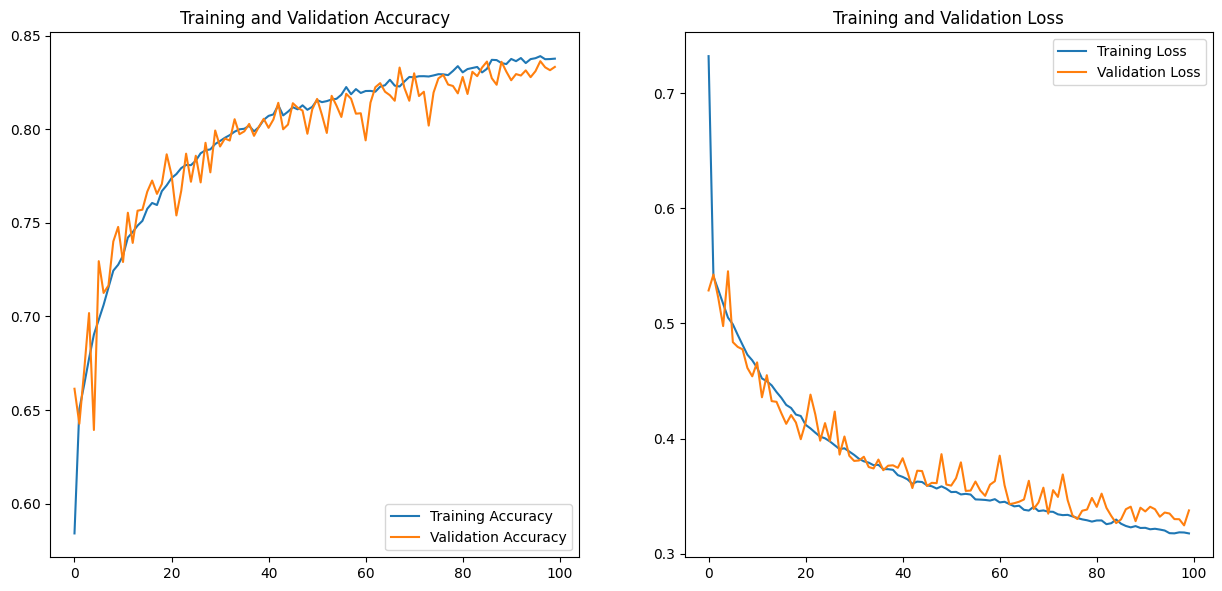

In [ ]:
epochs_range = range(EPOCHS)
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, history['Train Acc'], label='Training Accuracy')
plt.plot(epochs_range, history['Val Acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, history['Train Loss'], label='Training Loss')
plt.plot(epochs_range, history['Val Loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve, roc_curve, auc

def tune_threshold(threshold):
    best_f1, best_thres = 0, 0
    y_t, y_p = 0, 0
    for i in threshold:
        y_true, y_pred = model.eval(threshold=i)
        f1 = f1_score(y_true, y_pred, average='macro')
        if best_f1 < f1:
            best_f1, best_thres = f1, i
            y_t = y_true
            y_p = y_pred
    return best_thres, y_t, y_p

threshold, y_true, y_pred = tune_threshold(np.arange(0.65, 0.45, -0.01))

Validation: 100%|██████████| 286/286 [00:05<00:00, 52.66batch/s]


Precision: 0.8336
Recall: 0.8319
F1 Score: 0.8326
Akurasi: 0.8356
Threshold: 0.5400


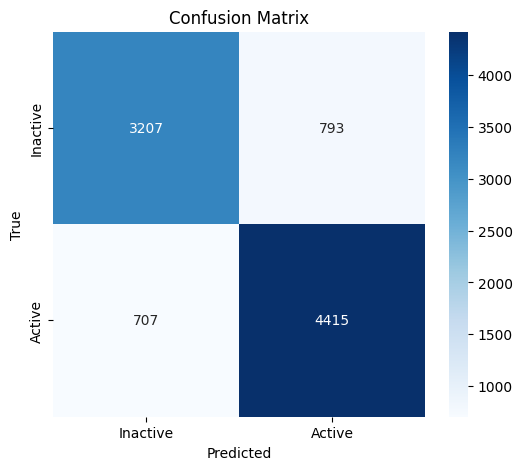

In [ ]:
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Akurasi: {accuracy:.4f}")
print(f"Threshold: {threshold:.4f}")

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Inactive', 'Active'], yticklabels=['Inactive', 'Active'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Validation: 100%|██████████| 286/286 [00:04<00:00, 61.25batch/s]


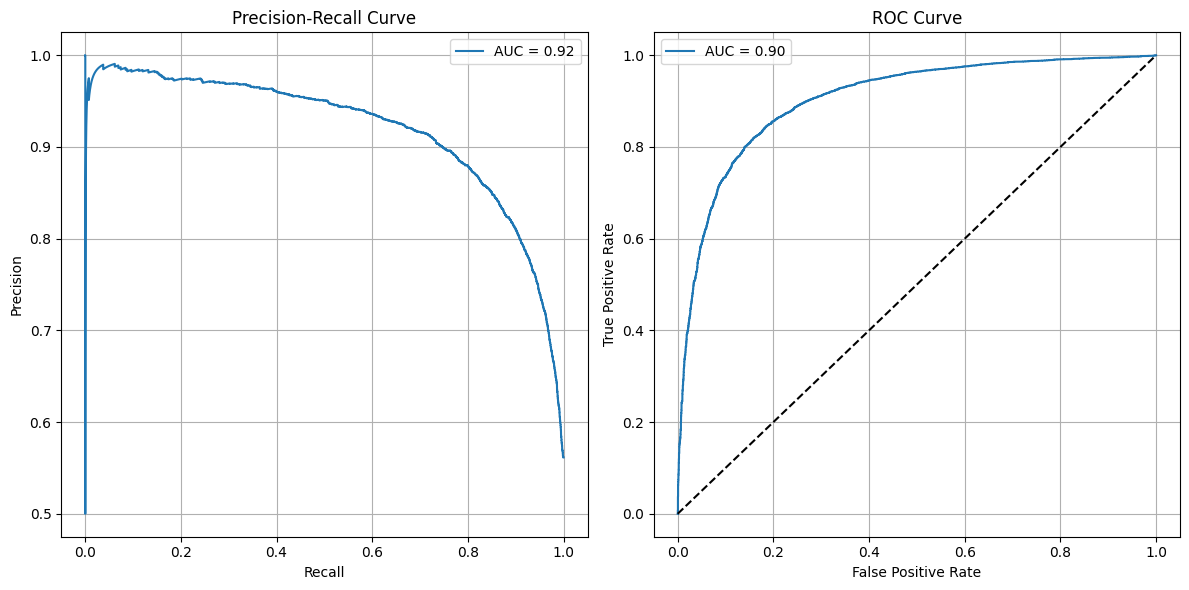

In [ ]:
y_true, y_scores = model.eval(probs=True)

precision, recall, _ = precision_recall_curve(y_true, y_scores)
fpr, tpr, _ = roc_curve(y_true, y_scores)

plt.figure(figsize=(12, 6))
for i, (x, y, xlabel, ylabel, title, auc_val) in enumerate([
    (recall, precision, 'Recall', 'Precision', 'Precision-Recall Curve', auc(recall, precision)),
    (fpr, tpr, 'False Positive Rate', 'True Positive Rate', 'ROC Curve', auc(fpr, tpr))], 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y, label=f'AUC = {auc_val:.2f}')
    if i == 2: plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.model, "bio.pt")
from google.colab import files
files.download('bio.pt')

In [32]:
model.load_model("bio.pt")

In [ ]:
def predict(model, molekul, threshold):
    prob = model.predict(molekul)
    pred = "active" if prob[0] > threshold else "inactive"
    return pred

print(predict(model, "Oc1cccc(-c2nc(N3CCOCC3)c3sccc3n2)c1", threshold))
print(predict(model, "CCn1c(=O)c2ccnn2c2cc(NC)c(C(=O)NCc3cccnc3)cc21", threshold))

active
inactive
